Machine learning analysis for condense-seq scores

In [1]:
# python modules
import copy
import random
import re
import glob
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import stats
import scipy.sparse as sparse
from scipy.stats import pearsonr
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [2]:
# custom modules
import graphics_edit as graphics
import load_file_edit as load_file
import Interval_dict
import statis_edit as statis

In [3]:
# matplotlib setting
%matplotlib inline
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"

In [4]:
### parameters
cell_org = {'H1':'human',
            'GM':'human',
            'mCD8T:WT':'mouse',
            'mCD8T:DFMO':'mouse',
            'mCD8T:ODCKO':'mouse'}

cell_chrnames = {'H1':['chr%s' % (i) for i in range(1, 23)] + ['chrX', 'chrY'],
                 'GM':['chr%s' % (i) for i in range(1, 23)] + ['chrX'],
                 'mCD8T:WT':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:DFMO':['chr%s' % (i) for i in range(1, 20)] + ['chrX'],
                 'mCD8T:ODCKO':['chr%s' % (i) for i in range(1, 20)] + ['chrX']}

In [5]:
### set data information (fname/field) and key
path = '/Users/sangwoopark/jhu_rockfish/2024_01_05_GEO/processed_files/'
dinfo_dkey = {'H1_NCP_sp_1rep_deep_chr1_score_table.gtab.gz':None}

In [6]:
### load gtab file
dkey_ID_value = {}
for fkey in dinfo_dkey:
    field_dkey = dinfo_dkey[fkey]

    if field_dkey == None:
        field_choices = None
    else:
        field_choices = field_dkey.keys()
    
    for fname in glob.glob(path + '*'):
        if not re.match(fkey, fname.rsplit('/')[-1]):
            continue
        print "loading %s" % (fname.rsplit('/')[-1])

        field_ID_value = load_file.read_gtab(fname,
                                             mode='col',
                                             field_choices=field_choices)

        if field_dkey == None:
            field_dkey = {field:field for field in field_ID_value.keys()}

        for field, dkey in field_dkey.items():
            ID_value = field_ID_value[field]
            if dkey not in dkey_ID_value:
                dkey_ID_value[dkey] = {}
            dkey_ID_value[dkey].update(ID_value)
            

loading H1_NCP_sp_1rep_deep_chr1_score_table.gtab.gz


In [7]:
# change dkey name
dkey_ID_value['AT content'] = copy.deepcopy(dkey_ID_value['ATcontent'])
del dkey_ID_value['ATcontent']

In [8]:
### compute sequence features
# methylation density
dkey_ID_value['meCpG density'] = statis.get_fract_dict(dkey_ID_value['CNumber(CpG)'],
                                                       dkey_ID_value['meCNumber(CpG)'],
                                                       div_error=0.0)
dkey_ID_value['meCHG density'] = statis.get_fract_dict(dkey_ID_value['CNumber(CHG)'],
                                                       dkey_ID_value['meCNumber(CHG)'],
                                                       div_error=0.0)
dkey_ID_value['meCHH density'] = statis.get_fract_dict(dkey_ID_value['CNumber(CHH)'],
                                                       dkey_ID_value['meCNumber(CHH)'],
                                                       div_error=0.0)


In [9]:
### compute sequence features
# mean poly GC length
ID_polyGC = {}
for ID, seq in dkey_ID_value['Sequence'].items():
    num_pos = statis.polynt_count(seq.upper(), nts='GC', pos=True)
    mean_len, count = 0.0, 0.0
    for num, pos in num_pos.items():
        mean_len += len(pos)*num
        count += len(pos)
    ID_polyGC[ID] = mean_len/count

dkey_ID_value['poly-G/C length'] = ID_polyGC

del dkey_ID_value['Sequence']
del ID_polyGC


In [10]:
### select feature set and target for analysis
feature_names = ['AT content', 'poly-G/C length', 'meCpG density', 'meCHG density', 'meCHH density', 'H2AFZ', 'H2AK5ac', 'H2BK120ac', 'H2BK12ac', 'H2BK15ac', 'H2BK20ac', 'H2BK5ac', 'H3K14ac', 'H3K18ac', 'H3K23ac', 'H3K23me2', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4ac', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K56ac', 'H3K79me1', 'H3K79me2', 'H3K9ac', 'H3K9me3', 'H4K20me1', 'H4K5ac', 'H4K8ac', 'H4K91ac']

target_name = 'H1_NCP_sp_8_1rep_deep'

In [27]:
### select machine learning methods
models = ["Linear reg", "SVR", "Boosting", "Random Forest", "Neural Network"]

In [12]:
### random sampling the data for analysis
ID_score = dkey_ID_value[target_name]

sample_size = 10**5
random.seed(123)
IDs = random.sample(ID_score.keys(),
                    sample_size)

In [13]:
### get features and targets
features = [[] for i in range(len(IDs))]
for feature_name in feature_names:
    values = [dkey_ID_value[feature_name][ID] for ID in IDs]
    min_value = min(values)
    max_value = max(values)
    for i in range(len(IDs)):
        value = values[i]
        if np.isnan(value):
            print ID
        re_value = float(value-min_value)/max_value
        features[i].append(re_value)
        if np.isnan(re_value):
            print ID
    del values
    del min_value
    del max_value
    del re_value

targets = [ID_score[ID] for ID in IDs]

del ID_score
del dkey_ID_value

In [14]:
### k-fold cross validation for machine learning models
k = 10
test_num = int(len(IDs)/10)

model_corrs = {}
model_importances = {}
for i in range(k):
    #print ("iteration %d/%d" % (i+1, k), file=sys.stderr)
    print "iteration %d/%d" % (i+1, k)
    st, ed = test_num*i, test_num*(i+1)
    test_features, test_targets = features[st:ed], targets[st:ed]
    train_features = features[:st] + features[ed:] 
    train_targets = targets[:st] + targets[ed:]

    
    # Linear regression
    alpha = 0.5
    reg = linear_model.Ridge(alpha=alpha)
    reg.fit(train_features, train_targets)
    corr, _ = pearsonr(test_targets, reg.predict(test_features))
    if "Linear reg" not in model_corrs:
        model_corrs["Linear reg"] = []
    model_corrs["Linear reg"].append(corr)
    #print ("Linear reg", corr, file=sys.stderr)
    print "Linear reg", corr


    # Supported Vector machine
    svm = SVR(gamma='scale')
    svm.fit(train_features, train_targets)
    corr, _ = pearsonr(test_targets, svm.predict(test_features))
    if "SVR" not in model_corrs:
        model_corrs["SVR"] = []
    model_corrs["SVR"].append(corr)
    #print ("SVM reg", corr, file=sys.stderr)
    print "SVM reg", corr


    # Boosting
    gb = GradientBoostingRegressor(min_samples_leaf=3,
                                   n_estimators=198,
                                   max_depth=20,
                                   max_features=2,
                                   min_samples_split=1000)
    gb.fit(train_features, train_targets)
    corr, _ = pearsonr(test_targets, gb.predict(test_features))
    if "Boosting" not in model_corrs:
        model_corrs["Boosting"] = []
    model_corrs["Boosting"].append(corr)
    #print ("Boosting reg", corr, file=sys.stderr)
    print "Boosting reg", corr
    if "Boosting" not in model_importances:
        model_importances["Boosting"] = []
    model_importances["Boosting"].append(gb.feature_importances_)

    
    # Random Forest
    rf = RandomForestRegressor(min_samples_leaf=3,
                               n_estimators=100,
                               max_depth=20,
                               max_features=3)
    rf.fit(train_features, train_targets)
    corr, _ = pearsonr(test_targets, rf.predict(test_features))
    if "Random Forest" not in model_corrs:
        model_corrs["Random Forest"] = []
    model_corrs["Random Forest"].append(corr)
    #print ("Random Forest reg", corr, file=sys.stderr)
    print "Random Forest reg", corr
    if "Random Forest" not in model_importances:
        model_importances["Random Forest"] = []
    model_importances["Random Forest"].append(rf.feature_importances_)


    # Neural Network (MLP)
    mlp = MLPRegressor(hidden_layer_sizes=(32,64,16),
                       max_iter=1000,
                       activation='tanh')
    mlp.fit(train_features, train_targets)
    corr, _ = pearsonr(test_targets, mlp.predict(test_features))
    if "Neural Network" not in model_corrs:
        model_corrs["Neural Network"] = []
    model_corrs["Neural Network"].append(corr)
    #print ("Neural Network(MLP) reg", corr, file=sys.stderr)
    print "Neural Network(MLP) reg", corr

    #print ('', file=sys.stderr)
    print ''

iteration 1/10
Linear reg 0.5810176587602567


SVM reg 0.6112608708621281


Boosting reg 0.6203556004684266


Random Forest reg 0.6165228120713552


Neural Network(MLP) reg 0.6151680256330117

iteration 2/10
Linear reg 0.5903203261552328


SVM reg 0.6141514818202196


Boosting reg 0.6286899213697016


Random Forest reg 0.6179941679895893


Neural Network(MLP) reg 0.6236903375987554

iteration 3/10
Linear reg 0.5716312613133829


SVM reg 0.599825886371873


Boosting reg 0.6099248978593207


Random Forest reg 0.6067692112765494


Neural Network(MLP) reg 0.6069432994742177

iteration 4/10
Linear reg 0.5727261328814347


SVM reg 0.6017945108459873


Boosting reg 0.6123502484018026


Random Forest reg 0.6061842934709546


Neural Network(MLP) reg 0.6083834218964689

iteration 5/10
Linear reg 0.5753353676012047


SVM reg 0.6024209118681103


Boosting reg 0.6144468758819209


Random Forest reg 0.605634626501465


Neural Network(MLP) reg 0.6109612048989316

iteration 6/10
Linear reg 0.5816396668920842


SVM reg 0.608615970696515


Boosting reg 0.6196236197907674


Random Forest reg 0.6136922219451756


Neural Network(MLP) reg 0.6158033923930918

iteration 7/10
Linear reg 0.5639830593874483


SVM reg 0.5872578235206031


Boosting reg 0.5995236108986298


Random Forest reg 0.5930602636252037


Neural Network(MLP) reg 0.5949658914510002

iteration 8/10
Linear reg 0.5767541668754456


SVM reg 0.6035703917884351


Boosting reg 0.6124480709479526


Random Forest reg 0.6089893584663763


Neural Network(MLP) reg 0.6100634841772236

iteration 9/10
Linear reg 0.581957922438997


SVM reg 0.6078379765606308


Boosting reg 0.6156130747601357


Random Forest reg 0.6125928493296253


Neural Network(MLP) reg 0.6131260589265614

iteration 10/10
Linear reg 0.5661637577961042


SVM reg 0.592156770730747


Boosting reg 0.6027432946868314


Random Forest reg 0.5994180748087834


Neural Network(MLP) reg 0.6012200106707517



In [15]:
# save the result
pickle.dump(model_corrs, open("model_corrs.pickle", "wb"))
pickle.dump(model_importances, open("model_importances.pickle", "wb"))

In [20]:
# print average correlation 
models = ["Linear reg", "SVR", "Boosting", "Random Forest", "Neural Network"]
for model in models:
    #print (model, np.mean(model_corrs[model]), file=sys.stderr)
    print model, np.mean(model_corrs[model])

Linear reg 0.576152932010159
SVR 0.6028892595065249
Boosting 0.6135719215065489
Random Forest 0.6080857879485078
Neural Network 0.6100325127120014


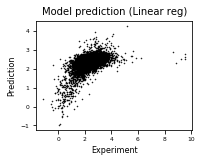

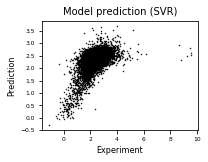

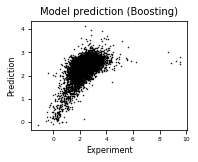

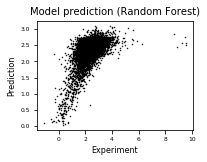

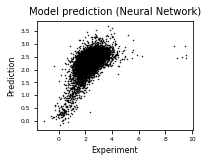

In [28]:
# plot scatter plot for prediction vs experiment
for model, m in zip(models, [reg, svm, gb, rf, mlp]):
    X = list(test_targets)
    Y = list(m.predict(test_features))
    pickle.dump([X, Y], open("ExpVSPred_%s.pickle" % (model), "wb"))
    fig = plt.figure(figsize=(2.8, 2))
    plt.plot(X, Y, 'k.', ms=1)
    plt.xlabel("Experiment", fontsize=8)
    plt.ylabel("Prediction", fontsize=8)
    plt.gca().tick_params(axis='both', which='major', labelsize=6)
    plt.gca().tick_params(axis='both', which='minor', labelsize=6)
    #minvalue, maxvalue = min(X+Y), max(X+Y)
    #plt.xlim([minvalue, maxvalue])
    #plt.ylim([minvalue, maxvalue])
    plt.title("Model prediction (%s)" % (model), fontsize=10)
    plt.savefig('ExpVSPre_%s.svg' % (model), format='svg', bbox_inches='tight')
    plt.show()
    plt.close()

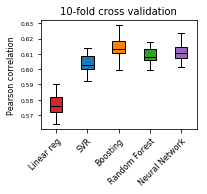

In [30]:
# plot bar plots for correlations
color_list = ['tab:red', 'tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
fig = plt.figure(figsize=(2.8, 2))
for i in range(len(models)):
    model = models[i]
    corrs = model_corrs[model]
    bp = plt.boxplot(corrs,
                     positions=[i],
                     patch_artist=True,
                     showfliers=False,
                     widths=[0.4])
    for patch in bp['boxes']:
        patch.set_facecolor(color_list[i])
    for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color='black')
plt.xticks(range(len(models)),
           models,
           rotation=45,
           fontsize=8,
           ha="right",
           rotation_mode="anchor")
plt.gca().tick_params('y', labelsize=6)
plt.ylabel("Pearson correlation", fontsize=8)
plt.title("10-fold cross validation", fontsize=10)
plt.xlim([-0.5, len(models)-0.5])
#plt.ylim([0.3, 0.8])
plt.savefig('Pearson_model.svg', format='svg', bbox_inches='tight')
plt.show()
plt.close()

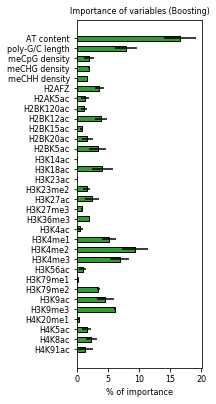

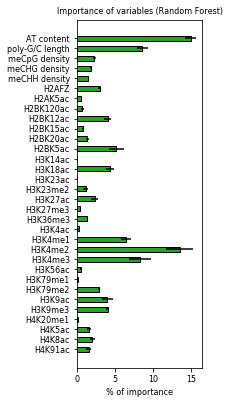

In [26]:
# plot bar plot for importances
models = ["Boosting", "Random Forest"]
for model in models:
    importances = np.asarray(model_importances[model])*100
    means = np.mean(importances, axis=0)
    stds = np.std(importances, axis=0)
    fig = plt.figure(figsize=(2.25, 6.4))
    ypos = [-i for i in range(len(feature_names))]
    plt.barh(ypos,
             means,
             xerr=stds,
             align='center',
             color='tab:green',
             height=0.5,
             edgecolor='k')
    plt.xlabel("% of importance", fontsize=8)
    plt.yticks(ypos, feature_names, fontsize=8)
    plt.title("Importance of variables (%s)" % (model) , fontsize=8)
    plt.gca().tick_params(axis='both', which='major', labelsize=8)
    plt.gca().tick_params(axis='both', which='minor', labelsize=8)
    #plt.savefig("Conditional_corr.png", bbox_inches='tight')
    plt.savefig(model+"_importance.svg", format='svg', bbox_inches='tight')
    plt.show()
    plt.close()